In [8]:
!pip install pedalboard
!pip install -q keras-tcn --no-dependencies

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tcn import TCN, tcn_full_summary
from pedalboard.io import AudioFile
from pedalboard import Pedalboard, Reverb
import math

In [10]:
sr = 44100

In [21]:
with AudioFile("clean.wav").resampled_to(sr) as i: cleanAudio_mono = i.read(i.frames)
with AudioFile("effect.wav").resampled_to(sr) as i: fxAudio = i.read(i.frames)

cleanAudio = np.array([cleanAudio_mono[0], cleanAudio_mono[0]])
print(cleanAudio.shape)
print(fxAudio.shape)

X_train = cleanAudio[:, :705000]
X_train = X_train.transpose((1, 0))
X_train = X_train.reshape((-1, 1000, 2))

Y_train = fxAudio[:, :705000]
Y_train = Y_train.transpose((1, 0))
Y_train = Y_train.reshape((-1, 1000, 2))

print(X_train.shape)
print(Y_train.shape)

# fxAudio is too difficult, let's try with a simple reverb
'''
board = Pedalboard([Reverb(room_size=0.25)])
fxAudio = board(cleanAudio, sr)
Y_train = processY(fxAudio, N)
'''

(2, 705600)
(2, 705600)
(705, 1000, 2)
(705, 1000, 2)


'\nboard = Pedalboard([Reverb(room_size=0.25)])\nfxAudio = board(cleanAudio, sr)\nY_train = processY(fxAudio, N)\n'

In [42]:
class nnModel:

    def __init__(self):

        input = tf.keras.Input(shape=(1000, 2))

        x = TCN(nb_filters=32,
                kernel_size=9,
                nb_stacks=32,
                dilations=(1, 2, 4, 8, 16, 32),
                padding='causal',
                use_skip_connections=True,
                dropout_rate=0.1,
                return_sequences=True,
                activation='relu',
                kernel_initializer='he_normal'
            )(input)

        x = TCN(nb_filters=2,
                kernel_size=9,
                nb_stacks=3,
                padding='causal',
                use_skip_connections=True,
                return_sequences=True,
                activation='relu',
                kernel_initializer='he_normal'
            )(input)

        model = tf.keras.models.Model(inputs=input, outputs=x)
        model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

        self.model = model

    def getInfo(self):
        self.model.summary()

    def trainNetwork(self, x, y, batchSize, epochs, verbose=1):
        return self.model.fit(x=x, y=y, batch_size=batchSize, epochs=epochs, verbose=verbose)

    def predict(self, batchAudioStereo):
        res = self.model.predict(batchAudioStereo)
        outputL = []
        outputR = []
        res = res.transpose((0, 2, 1))
        for i in range(res.shape[0]):
            for sample in res[i, 0]:
                outputL.append(sample)
            for sample in res[i, 1]:
                outputR.append(sample)
        return np.array([np.array(outputL), np.array(outputR)])

In [43]:
neuralNetwork = nnModel()
neuralNetwork.getInfo()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000, 2)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 1000, 2)           1368      
                                                                 
Total params: 1368 (5.34 KB)
Trainable params: 1368 (5.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
EPOCHS = 10
history = neuralNetwork.trainNetwork(X_train, Y_train, 32, EPOCHS)

Epoch 1/10
23/23 [==============================] - 16s 261ms/step - loss: 39.6986 - mse: 39.6986 - mae: 2.3119
Epoch 2/10
23/23 [==============================] - 6s 271ms/step - loss: 2.2495 - mse: 2.2495 - mae: 0.3635
Epoch 3/10
23/23 [==============================] - 6s 265ms/step - loss: 1.4791 - mse: 1.4791 - mae: 0.2652
Epoch 4/10
23/23 [==============================] - 6s 261ms/step - loss: 1.1166 - mse: 1.1166 - mae: 0.2163
Epoch 5/10
23/23 [==============================] - 7s 275ms/step - loss: 0.6569 - mse: 0.6569 - mae: 0.1794
Epoch 6/10
23/23 [==============================] - 6s 248ms/step - loss: 0.3821 - mse: 0.3821 - mae: 0.1566
Epoch 7/10
23/23 [==============================] - 7s 287ms/step - loss: 0.3296 - mse: 0.3296 - mae: 0.1473
Epoch 8/10
23/23 [==============================] - 6s 246ms/step - loss: 0.3039 - mse: 0.3039 - mae: 0.1401
Epoch 9/10
23/23 [==============================] - 7s 293ms/step - loss: 0.2794 - mse: 0.2794 - mae: 0.1332
Epoch 10/10
23/2

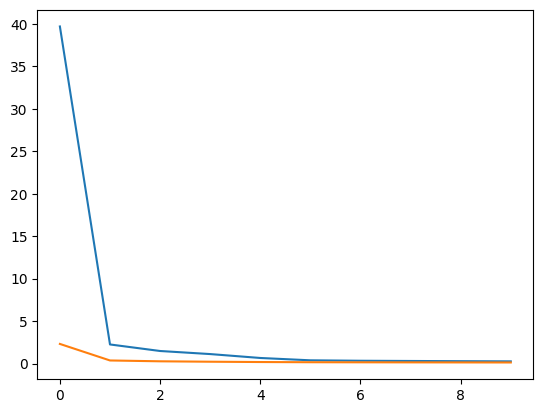

In [45]:
plt.plot(range(EPOCHS), history.history['mse'])
plt.plot(range(EPOCHS), history.history['mae'])
plt.show()

In [46]:
with AudioFile("loop.wav").resampled_to(sr) as i: loop_mono = i.read(i.frames)
loop = np.array([loop_mono[0], loop_mono[0]])
#loop = processSequenceToBatch(loop, N, M)

new_loop = loop[:,:360000]
new_loop = new_loop.transpose((1, 0))
new_loop = new_loop.reshape((-1, 1000, 2))

output = neuralNetwork.predict(new_loop)

with AudioFile('processed-output.wav', 'w', sr, output.shape[0]) as f: f.write(output)

12/12 [==============================] - 2s 77ms/step
